## Summary -> <br>
In this notebook, we'll learn how to perform Siamese Classification. <br> 

Siamese Classification is a One-Shot Learning primarily used in Facial Recognition, Signature Verfication. <br>

Data Preparation for Siamese Network Learning is usually a challenge to deal with. <br>
Apart from that, comes the network architecture, which has two inputs feeding to a common network architecture. <br>
<br>
Let's begin step by step.

#### Necessary Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda 
from tensorflow.keras.optimizers import RMSprop 
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.python.keras.utils.vis_utils import plot_model 
from tensorflow.keras import backend as K 


import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image, ImageFont, ImageDraw 
import random

In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Activation, Dropout
from keras.models import Model, Sequential 
from keras.regularizers import l2 
from keras import backend as K 
from keras.optimizers import Adam 
from skimage.io import imshow 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random

## Loading the Dataset

Using a already processed provided [here](https://www.kaggle.com/arpandhatt/package-data), we'll apply the preprocessing needed for training a Siamese Network Model. 

In [3]:
npz = np.load('../input/package-data/input_data.npz')
X_train = npz['X_train']
Y_train = npz['Y_train']

del npz 

print(f"We have {Y_train.shape[0] - 1000} examples to work with")

We have 3113 examples to work with


### Developing the Siamese Network Model

In [4]:
left_input = Input((75,75,3))
right_input = Input((75,75,3))


convnet = Sequential([
  Conv2D(5,3,input_shape = (75,75,3)),
    Activation('relu'),  
    MaxPooling2D(),
    Conv2D(5,3),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    MaxPooling2D(),
    Conv2D(7,2),
    Activation('relu'),
    Flatten(),
    Dense(18),
    Activation('sigmoid')
])


encoded_l = convnet(left_input)
encoded_r = convnet(right_input)

L1_layer = Lambda(lambda tensor : K.abs(tensor[0] - tensor[1]))

L1_distance = L1_layer([encoded_l, encoded_r])


prediction = Dense(1, activation = 'sigmoid')(L1_distance)
siamese_net = Model(inputs = [left_input, right_input], outputs = prediction)

optimizer = Adam(0.001, decay = 2.5e-4)
siamese_net.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

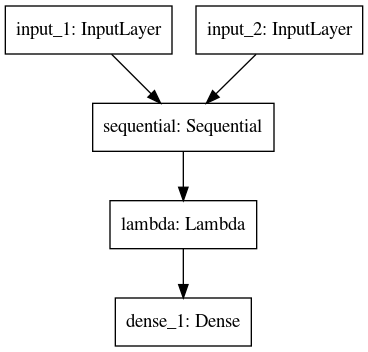

In [5]:
plot_model(siamese_net)

#### Preprocessing the Dataset

We're taking 1000 samples into consideration for initial model training.

In [6]:
image_list = np.split(X_train[:1000], 1000)
label_list = np.split(Y_train[:1000], 1000)


Preparing the test dataset

In [7]:
iceimage = X_train[101]
test_left = []
test_right = []
test_targets = []


for i in range(Y_train.shape[0] - 1000):
    test_left.append(iceimage)
    test_right.append(X_train[i + 1000])
    test_targets.append(Y_train[i + 1000])
    
test_left = np.squeeze(np.array(test_left))
test_right = np.squeeze(np.array(test_right))
test_targets = np.squeeze(np.array(test_targets))

For each image, 10 pairs are created of which 6 are same & 4 are different.

In [8]:
"""
Train Data Creation
"""

left_input = []
right_input = []
targets = []

# define the number of same pairs to be created per image
same = 6
# define the number of different pairs to be created per image
diff = 4



for i in range(len(image_list)):
    
    # obtain the label of the ith image
    label_i = int(label_list[i])
    #print(label_i)
    
    # get same pairs
    print("-"* 10 ); print("Same")
    # randomly select 'same' number of items for the images with the 'same' label as that of ith image.
    print(random.sample(list(np.where(np.array(label_list) == label_i)[0]), same))
    
    for j in random.sample(list(np.where(np.array(label_list) == label_i)[0]), same):
        left_input.append(image_list[i])
        right_input.append(image_list[j])
        targets.append(1.)
        
    
    # get diff pairs
    print('='*10); print("Different")
    # randomly select 'same' number of items for the images with the 'same' label as that of ith image.
    print(random.sample(list(np.where(np.array(label_list) != label_i)[0]), diff))
    
    for j in random.sample(list(np.where(np.array(label_list) != label_i)[0]), diff):
        left_input.append(image_list[i])
        right_input.append(image_list[j])
        targets.append(0.)
    

----------
Same
[877, 211, 294, 162, 258, 263]
Different
[51, 665, 6, 74]
----------
Same
[721, 826, 952, 794, 622, 402]
Different
[238, 218, 336, 470]
----------
Same
[604, 75, 454, 533, 345, 869]
Different
[530, 17, 292, 897]
----------
Same
[67, 938, 824, 794, 998, 908]
Different
[321, 492, 371, 66]
----------
Same
[850, 921, 794, 822, 902, 722]
Different
[391, 930, 321, 376]
----------
Same
[173, 363, 846, 708, 872, 869]
Different
[341, 386, 374, 603]
----------
Same
[832, 688, 810, 728, 899, 570]
Different
[829, 192, 879, 674]
----------
Same
[149, 989, 707, 301, 788, 155]
Different
[66, 611, 84, 38]
----------
Same
[57, 485, 697, 62, 187, 836]
Different
[28, 337, 110, 264]
----------
Same
[79, 594, 466, 4, 448, 420]
Different
[961, 802, 621, 677]
----------
Same
[929, 309, 624, 815, 12, 728]
Different
[374, 276, 584, 56]
----------
Same
[602, 670, 37, 413, 900, 664]
Different
[432, 600, 898, 200]
----------
Same
[26, 957, 103, 425, 468, 961]
Different
[671, 180, 22, 670]
--------

In [9]:
left_input = np.squeeze(np.array(left_input))
right_input = np.squeeze(np.array(right_input))
targets = np.squeeze(np.array(targets))

## Begin Model Training

In [10]:
siamese_net.summary()



siamese_net.fit([left_input, right_input], targets, batch_size = 16, epochs = 30, verbose = 1, 
               validation_data = ([test_left, test_right], test_targets))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 18)           6912        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 18)           0           sequential[0][0]             